**Датасет из ПР1**
[https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption?resource=download](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption?resource=download)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('C:/Users/Ivan/Desktop/jupyter/powerconsumption.csv')

# Добавление нового атрибута

Новый атрибут: **TotalPowerConsumption** (Сумма потребления энергии по всем зонам)

In [51]:
df['TotalPowerConsumption'] = df['PowerConsumption_Zone1'] + df['PowerConsumption_Zone2'] + df['PowerConsumption_Zone3']
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,TotalPowerConsumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,65489.23209
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,63650.44627


# Предобработка данных

**Проверка на пропущенные значения**

In [52]:
print(df.isnull().sum())

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
TotalPowerConsumption     0
dtype: int64


**Проверка на дубликаты**

In [53]:
print(f"\nКоличество дубликатов: {df.duplicated().sum()}")


Количество дубликатов: 0


**Основная информация о данных**

In [54]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
 9   TotalPowerConsumption   52416 non-null  float64
dtypes: float64(9), object(1)
memory usage: 4.0+ MB
None


**Статистическое описание**

In [55]:
print(df.describe())

        Temperature      Humidity     WindSpeed  GeneralDiffuseFlows  \
count  52416.000000  52416.000000  52416.000000         52416.000000   
mean      18.810024     68.259518      1.959489           182.696614   
std        5.815476     15.551177      2.348862           264.400960   
min        3.247000     11.340000      0.050000             0.004000   
25%       14.410000     58.310000      0.078000             0.062000   
50%       18.780000     69.860000      0.086000             5.035500   
75%       22.890000     81.400000      4.915000           319.600000   
max       40.010000     94.800000      6.483000          1163.000000   

       DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
count  52416.000000            52416.000000            52416.000000   
mean      75.028022            32344.970564            21042.509082   
std      124.210949             7130.562564             5201.465892   
min        0.011000            13895.696200             8560.081466

**Удаление выбросов**

In [56]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
numeric_columns = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 
                  'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 
                  'PowerConsumption_Zone3', 'TotalPowerConsumption']

original_size = len(df)
for col in numeric_columns:
    df = remove_outliers(df, col)
print(f"Удалено {original_size - len(df)} выбросов")

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

Удалено 8483 выбросов


# Визуализация данных и поиск кластеров

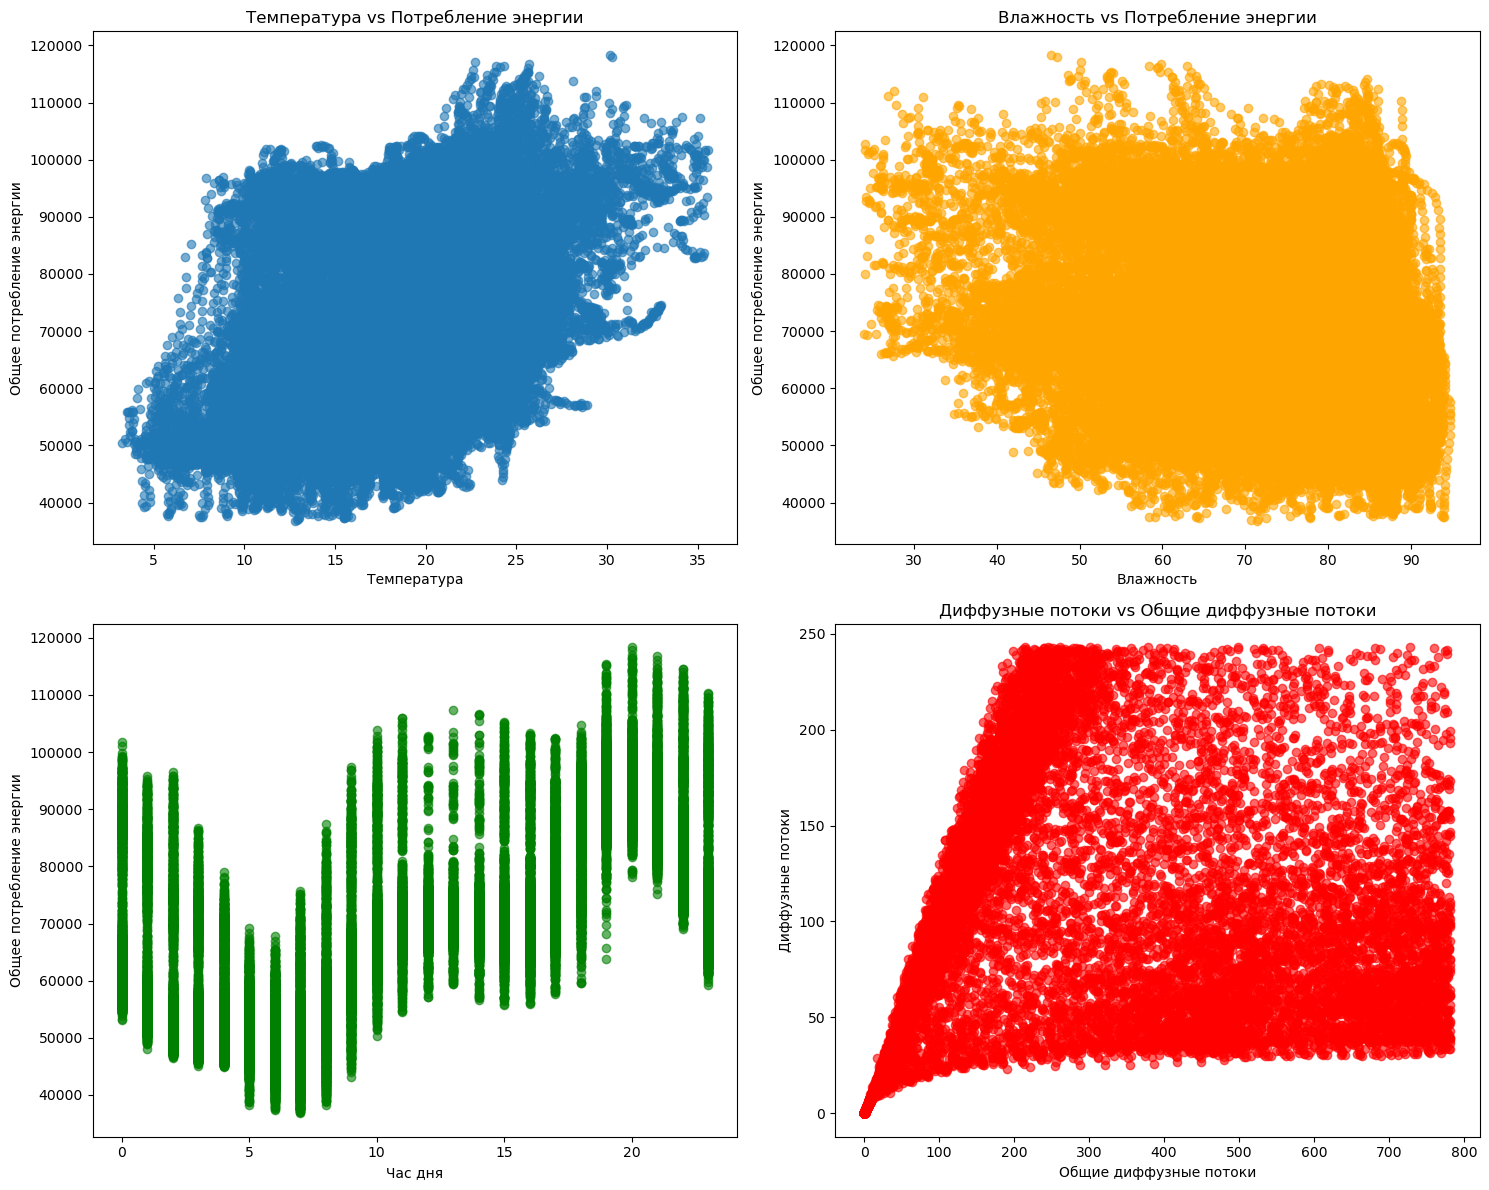

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].scatter(df['Temperature'], df['TotalPowerConsumption'], alpha=0.6)
axes[0,0].set_xlabel('Температура')
axes[0,0].set_ylabel('Общее потребление энергии')
axes[0,0].set_title('Температура vs Потребление энергии')

axes[0,1].scatter(df['Humidity'], df['TotalPowerConsumption'], alpha=0.6, color='orange')
axes[0,1].set_xlabel('Влажность')
axes[0,1].set_ylabel('Общее потребление энергии')
axes[0,1].set_title('Влажность vs Потребление энергии')

axes[1,0].scatter(df['Hour'], df['TotalPowerConsumption'], alpha=0.6, color='green')
axes[1,0].set_xlabel('Час дня')
axes[1,0].set_ylabel('Общее потребление энергии')
axes[1,1].set_title('Время суток vs Потребление энергии')

axes[1,1].scatter(df['GeneralDiffuseFlows'], df['DiffuseFlows'], alpha=0.6, color='red')
axes[1,1].set_xlabel('Общие диффузные потоки')
axes[1,1].set_ylabel('Диффузные потоки')
axes[1,1].set_title('Диффузные потоки vs Общие диффузные потоки')

plt.tight_layout()
plt.show()

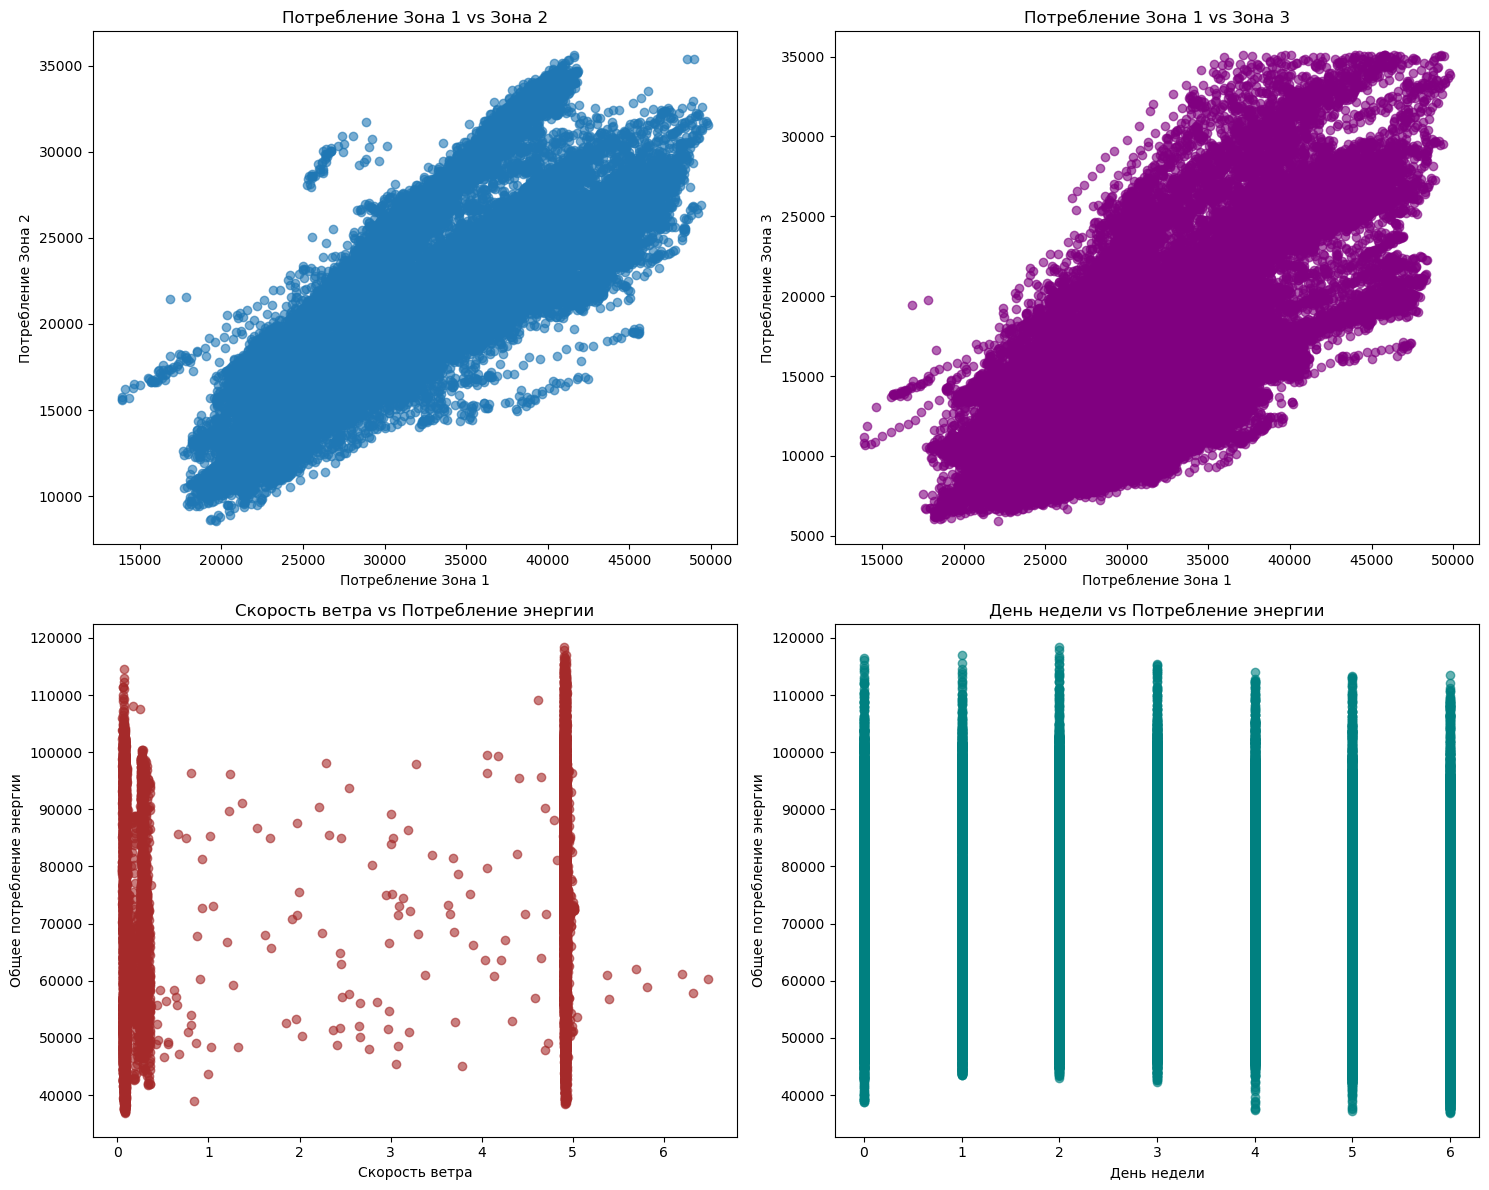

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].scatter(df['PowerConsumption_Zone1'], df['PowerConsumption_Zone2'], alpha=0.6)
axes[0,0].set_xlabel('Потребление Зона 1')
axes[0,0].set_ylabel('Потребление Зона 2')
axes[0,0].set_title('Потребление Зона 1 vs Зона 2')

axes[0,1].scatter(df['PowerConsumption_Zone1'], df['PowerConsumption_Zone3'], alpha=0.6, color='purple')
axes[0,1].set_xlabel('Потребление Зона 1')
axes[0,1].set_ylabel('Потребление Зона 3')
axes[0,1].set_title('Потребление Зона 1 vs Зона 3')

axes[1,0].scatter(df['WindSpeed'], df['TotalPowerConsumption'], alpha=0.6, color='brown')
axes[1,0].set_xlabel('Скорость ветра')
axes[1,0].set_ylabel('Общее потребление энергии')
axes[1,0].set_title('Скорость ветра vs Потребление энергии')

axes[1,1].scatter(df['DayOfWeek'], df['TotalPowerConsumption'], alpha=0.6, color='teal')
axes[1,1].set_xlabel('День недели')
axes[1,1].set_ylabel('Общее потребление энергии')
axes[1,1].set_title('День недели vs Потребление энергии')

plt.tight_layout()
plt.show()

# Кластеризация K-means

In [63]:
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 
           'DiffuseFlows', 'TotalPowerConsumption', 'Hour']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
    if k > 1:
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

**График метода локтя**

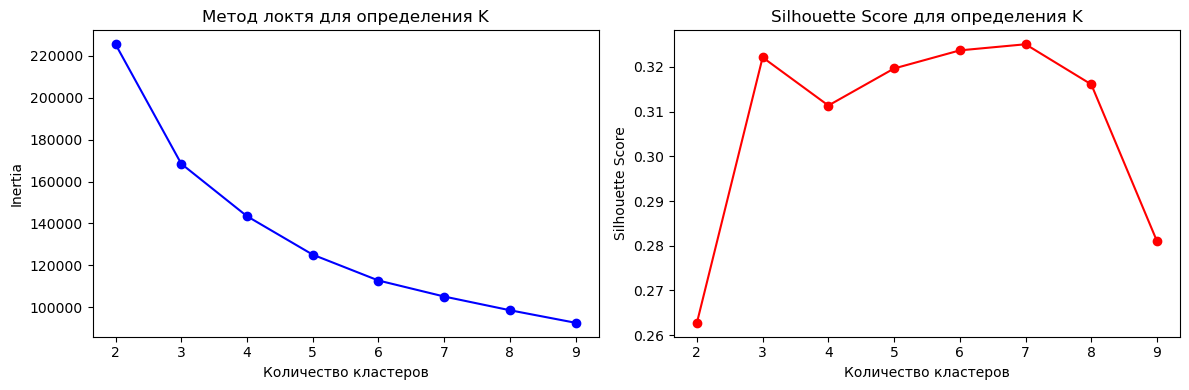

In [64]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения K')

plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette_scores, 'ro-')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для определения K')

plt.tight_layout()
plt.show()

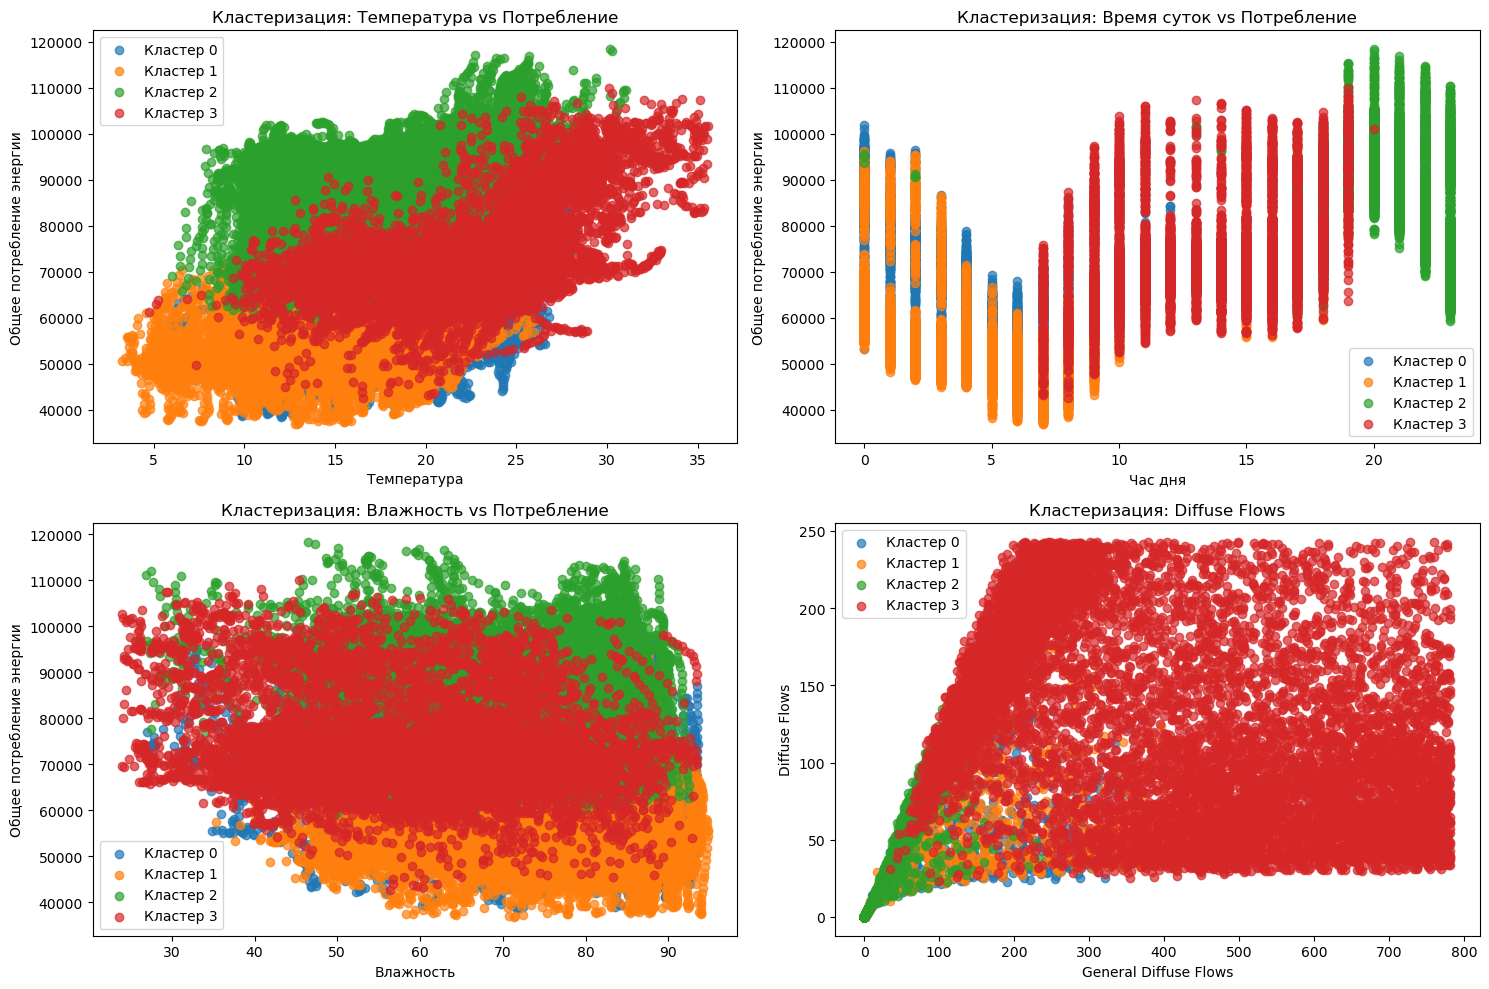

In [65]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Temperature'], cluster_data['TotalPowerConsumption'], 
               label=f'Кластер {cluster}', alpha=0.7)
plt.xlabel('Температура')
plt.ylabel('Общее потребление энергии')
plt.legend()
plt.title('Кластеризация: Температура vs Потребление')

plt.subplot(2, 2, 2)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Hour'], cluster_data['TotalPowerConsumption'], 
               label=f'Кластер {cluster}', alpha=0.7)
plt.xlabel('Час дня')
plt.ylabel('Общее потребление энергии')
plt.legend()
plt.title('Кластеризация: Время суток vs Потребление')

plt.subplot(2, 2, 3)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Humidity'], cluster_data['TotalPowerConsumption'], 
               label=f'Кластер {cluster}', alpha=0.7)
plt.xlabel('Влажность')
plt.ylabel('Общее потребление энергии')
plt.legend()
plt.title('Кластеризация: Влажность vs Потребление')

plt.subplot(2, 2, 4)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['GeneralDiffuseFlows'], cluster_data['DiffuseFlows'], 
               label=f'Кластер {cluster}', alpha=0.7)
plt.xlabel('General Diffuse Flows')
plt.ylabel('Diffuse Flows')
plt.legend()
plt.title('Кластеризация: Diffuse Flows')

plt.tight_layout()
plt.show()

In [66]:
cluster_analysis = df.groupby('Cluster')[features].mean()
print("Средние значения по кластерам:")
print(cluster_analysis)

Средние значения по кластерам:
         Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
Cluster                                                                         
0          19.548430  74.546238   4.893474            25.119798     13.580954   
1          14.329473  77.147265   0.113377            25.161903     14.621049   
2          17.491943  70.562743   1.454317            10.493425      9.728176   
3          21.769243  59.016614   2.332529           409.551702    123.641169   

         TotalPowerConsumption       Hour  
Cluster                                    
0                 61267.554408   4.371334  
1                 55176.295657   4.670331  
2                 87106.813876  20.353378  
3                 73493.589022  13.381325  


In [67]:
cluster_sizes = df['Cluster'].value_counts().sort_index()
print(f"\nРазмеры кластеров:\n{cluster_sizes}")


Размеры кластеров:
Cluster
0     7535
1    13553
2    11857
3    10988
Name: count, dtype: int64


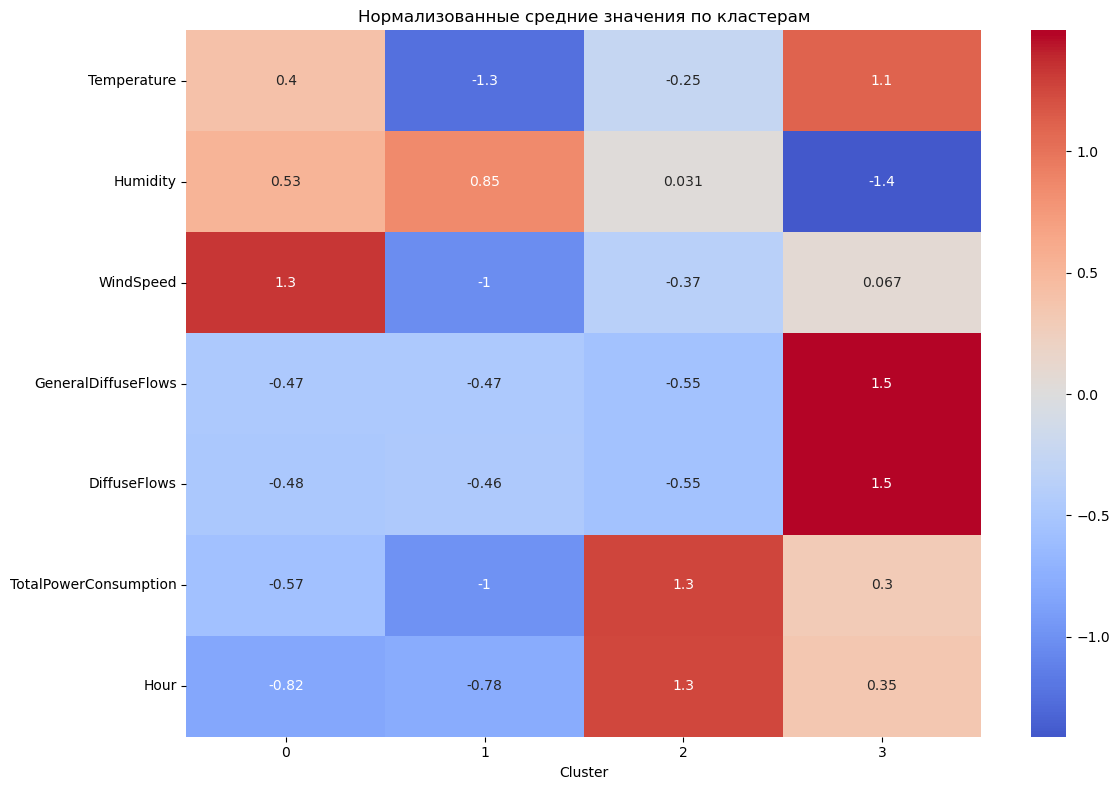

In [68]:
plt.figure(figsize=(12, 8))
cluster_analysis_normalized = (cluster_analysis - cluster_analysis.mean()) / cluster_analysis.std()

sns.heatmap(cluster_analysis_normalized.T, annot=True, cmap='coolwarm', center=0)
plt.title('Нормализованные средние значения по кластерам')
plt.tight_layout()
plt.show()

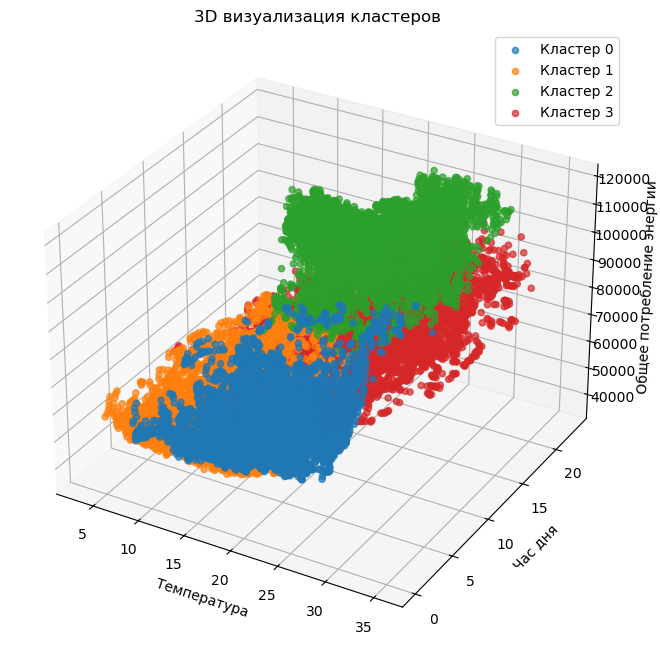

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    ax.scatter(cluster_data['Temperature'], 
              cluster_data['Hour'], 
              cluster_data['TotalPowerConsumption'],
              label=f'Кластер {cluster}', alpha=0.7)

ax.set_xlabel('Температура')
ax.set_ylabel('Час дня')
ax.set_zlabel('Общее потребление энергии')
ax.set_title('3D визуализация кластеров')
ax.legend()
plt.show()

In [70]:
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"Кластер {cluster} (размер: {len(cluster_data)}):")
    print(f"  - Средняя температура: {cluster_data['Temperature'].mean():.2f}°C")
    print(f"  - Средняя влажность: {cluster_data['Humidity'].mean():.2f}%")
    print(f"  - Среднее потребление: {cluster_data['TotalPowerConsumption'].mean():.2f}")
    print(f"  - Типичное время: {cluster_data['Hour'].mode().iloc[0]}:00")
    print(f"  - Средняя скорость ветра: {cluster_data['WindSpeed'].mean():.2f}")
    print()

Кластер 0 (размер: 7535):
  - Средняя температура: 19.55°C
  - Средняя влажность: 74.55%
  - Среднее потребление: 61267.55
  - Типичное время: 6:00
  - Средняя скорость ветра: 4.89

Кластер 1 (размер: 13553):
  - Средняя температура: 14.33°C
  - Средняя влажность: 77.15%
  - Среднее потребление: 55176.30
  - Типичное время: 1:00
  - Средняя скорость ветра: 0.11

Кластер 2 (размер: 11857):
  - Средняя температура: 17.49°C
  - Средняя влажность: 70.56%
  - Среднее потребление: 87106.81
  - Типичное время: 23:00
  - Средняя скорость ветра: 1.45

Кластер 3 (размер: 10988):
  - Средняя температура: 21.77°C
  - Средняя влажность: 59.02%
  - Среднее потребление: 73493.59
  - Типичное время: 16:00
  - Средняя скорость ветра: 2.33



# Выводы
Проведенная кластеризация методом K-means успешно выявила скрытые паттерны энергопотребления, демонстрируя различные режимы работы энергосистемы. Анализ показал, что потребление энергии тесно связано с временем суток и температурными условиями, формируя устойчивые группы с характерными особенностями. Выделенные кластеры отражают типичные сценарии нагрузки, такие как утренние и вечерние пики, а также периоды низкого потребления. Полученные результаты позволяют глубже понять структуру энергопотребления и выявить факторы, влияющие на его динамику. Кластеризация подтвердила существование естественных групп в данных, что свидетельствует о систематическом характере энергопотребления.